### Key Steps for Exploratory Data Analysis (EDA)
* Reading dataset
* Analyzing the data
* Checking for the duplicates
* Missing Values Calculation
* Analyzing the dataset:
* Univariate Analysis
* Bivariate Analysis
* Multivariate Analysis

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wr
wr.filterwarnings('ignore')

df = pd.read_csv("Datasets\Tech_Stock_Data_2019-2025.csv")
print(df.head())

         Date      NVDA        AMD       INTC      GOOGL       MSFT  \
0  2019-01-01       NaN        NaN        NaN        NaN        NaN   
1  2019-01-02  3.377354  18.830000  40.518055  52.372784  94.612602   
2  2019-01-03  3.173305  17.049999  38.289036  50.922279  91.131996   
3  2019-01-04  3.376611  19.000000  40.638535  53.534267  95.370476   
4  2019-01-05       NaN        NaN        NaN        NaN        NaN   

          CRM       ORCL       OKTA         ZS  ...  VIX_MA20  VIX_vs_MA  \
0         NaN        NaN        NaN        NaN  ...       NaN        NaN   
1  134.139008  40.754517  63.259998  39.810001  ...       NaN        NaN   
2  129.042572  40.357971  59.560001  39.320000  ...       NaN        NaN   
3  136.523895  42.097385  63.150002  41.770000  ...       NaN        NaN   
4         NaN        NaN        NaN        NaN  ...       NaN        NaN   

   Vol_of_Vol_Ratio  Semi_vs_Tech_Ratio  Small_vs_Large_Caps  NASDAQ_MA5  \
0               NaN                 NaN 

In [41]:
df.shape
print("\n====Detailed Overview=====")
df.info()



====Detailed Overview=====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Columns: 103 entries, Date to Credit_Spread_Proxy
dtypes: float64(84), int64(18), object(1)
memory usage: 2.0+ MB


In [42]:
df.columns.tolist()

['Date',
 'NVDA',
 'AMD',
 'INTC',
 'GOOGL',
 'MSFT',
 'CRM',
 'ORCL',
 'OKTA',
 'ZS',
 'CRWD',
 'DDOG',
 'NET',
 'AAPL',
 'META',
 'AMZN',
 'IBM',
 'ADBE',
 'NOW',
 'SHOP',
 'TWLO',
 'MDB',
 'PYPL',
 'ANET',
 'PANW',
 'SP500',
 'NASDAQ',
 'Dow_Jones',
 'Russell2000',
 'VIX',
 'VVIX',
 'NASDAQ_VIX',
 'Treasury_10Y',
 'Treasury_3M',
 'Treasury_5Y',
 'Treasury_30Y',
 'Yield_Curve_Slope',
 'Yield_Curve_Inverted',
 'Semiconductor_ETF',
 'AI_Robotics_ETF',
 'Cybersecurity_ETF',
 'ARK_Autonomous_Tech',
 'Taiwan_ETF',
 'Cloud_Computing_ETF',
 'Software_ETF',
 'South_Korea_ETF',
 'NASDAQ_100_ETF',
 'China_Large_Cap_ETF',
 'Global_Robotics_ETF',
 'Real_Estate_ETF',
 'Tech_Sector_ETF',
 'Global_Cloud_ETF',
 'Japan_ETF',
 'ARK_Next_Gen_Internet',
 'ARK_Innovation',
 'Dollar_Index',
 'Dollar_Strength',
 'Gold',
 'Silver',
 'Copper',
 'Oil_WTI',
 'Natural_Gas',
 'Gold_Oil_Ratio',
 'Bitcoin',
 'Ethereum',
 'Crypto_Tech_Corr_20d',
 'Pandemic_Period',
 'AI_Boom_Period',
 'Fed_Hike_Period',
 'Tech_Bear

In [43]:
df.nunique()

Date                   2516
NVDA                   1721
AMD                    1630
INTC                   1615
GOOGL                  1711
                       ... 
NASDAQ_MA5              294
NASDAQ_MA20               0
NASDAQ_Momentum           0
Dollar_MA20               0
Credit_Spread_Proxy    1733
Length: 103, dtype: int64

In [44]:
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.set_index("Date", inplace=True)

### Univariate Analysis

In [45]:
df.describe()

,NVDA,AMD,INTC,GOOGL,MSFT,CRM,ORCL,OKTA,ZS,CRWD,...,VIX_MA20,VIX_vs_MA,Vol_of_Vol_Ratio,Semi_vs_Tech_Ratio,Small_vs_Large_Caps,NASDAQ_MA5,NASDAQ_MA20,NASDAQ_Momentum,Dollar_MA20,Credit_Spread_Proxy
count,1733.000000,1733.000000,1733.000000,1733.000000,1733.000000,1733.000000,1733.000000,1733.000000,1733.000000,1622.000000,...,0.0,0.0,1725.000000,1733.000000,1733.000000,294.000000,0.0,0.0,0.0,1733.000000
mean,47.900993,98.261448,38.832704,119.984913,285.457588,216.970655,97.475365,130.124743,167.481021,217.579436,...,NaN,NaN,5.354141,0.891305,0.454944,13454.367840,NaN,NaN,NaN,0.657674
std,53.580672,47.089996,11.045563,47.794091,113.970381,52.667203,55.488603,64.291771,75.670943,121.416443,...,NaN,NaN,1.123853,0.135921,0.062077,3991.609257,NaN,NaN,NaN,0.148985
min,3.173305,17.049999,18.129999,50.922279,91.131996,123.006073,36.643833,45.020000,39.320000,33.009998,...,NaN,NaN,2.054459,0.677251,0.346835,6927.020020,NaN,NaN,NaN,0.359187
25%,12.336245,66.300003,29.256401,76.831589,202.020081,165.212097,53.353050,83.199997,112.269997,128.520000,...,NaN,NaN,4.512173,0.772029,0.399018,10795.564990,NaN,NaN,NaN,0.541143
50%,20.657600,94.559998,41.241623,117.969360,272.426819,215.166611,79.704979,101.160004,169.630005,190.940002,...,NaN,NaN,5.527798,0.871637,0.457192,13306.102930,NaN,NaN,NaN,0.613796
75%,79.072350,125.269997,47.764519,147.031921,387.890564,255.063278,115.224899,182.800003,211.429993,292.464996,...,NaN,NaN,6.207071,1.004691,0.508247,15823.710547,NaN,NaN,NaN,0.799461
max,207.039993,264.329987,62.083336,292.809998,541.057373,365.656708,327.761200,291.779999,368.779999,557.530029,...,NaN,NaN,8.019528,1.218272,0.596649,23745.904687,NaN,NaN,NaN,0.937015


In [46]:
# Check missing values
print("Missing values per column:")
missing_values = df.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0].head(20))

Missing values per column:
VIX_vs_MA               2516
NASDAQ_MA20             2516
VIX_MA20                2516
Dollar_MA20             2516
Dollar_Strength         2516
Crypto_Tech_Corr_20d    2516
NASDAQ_Momentum         2516
NASDAQ_MA5              2222
DDOG                     963
NET                      959
CRWD                     894
Global_Cloud_ETF         855
Vol_of_Vol_Ratio         791
VVIX                     791
CRM                      783
MSFT                     783
GOOGL                    783
INTC                     783
ZS                       783
OKTA                     783
dtype: int64


### Bivariate Analysis - Stock Performance Comparisons

In [47]:
# AI-Focused Tech Stock Comparative Analysis
# Define stock categories
ai_hardware = ['NVDA', 'AMD', 'INTC']
ai_cloud = ['GOOGL', 'MSFT', 'CRM', 'ORCL', 'NOW']
cybersecurity = ['OKTA', 'ZS', 'CRWD', 'NET', 'PANW']
big_tech = ['AAPL', 'META', 'AMZN', 'IBM']
software = ['ADBE', 'SHOP', 'TWLO', 'MDB', 'DDOG', 'PYPL', 'ANET']

# Calculate daily returns for time series analysis
stock_cols = ai_hardware + ai_cloud + cybersecurity + big_tech + software
for col in stock_cols:
    if col in df.columns:
        df[f'{col}_Return'] = df[col].pct_change() * 100

print("Daily returns calculated for all stocks")

Daily returns calculated for all stocks


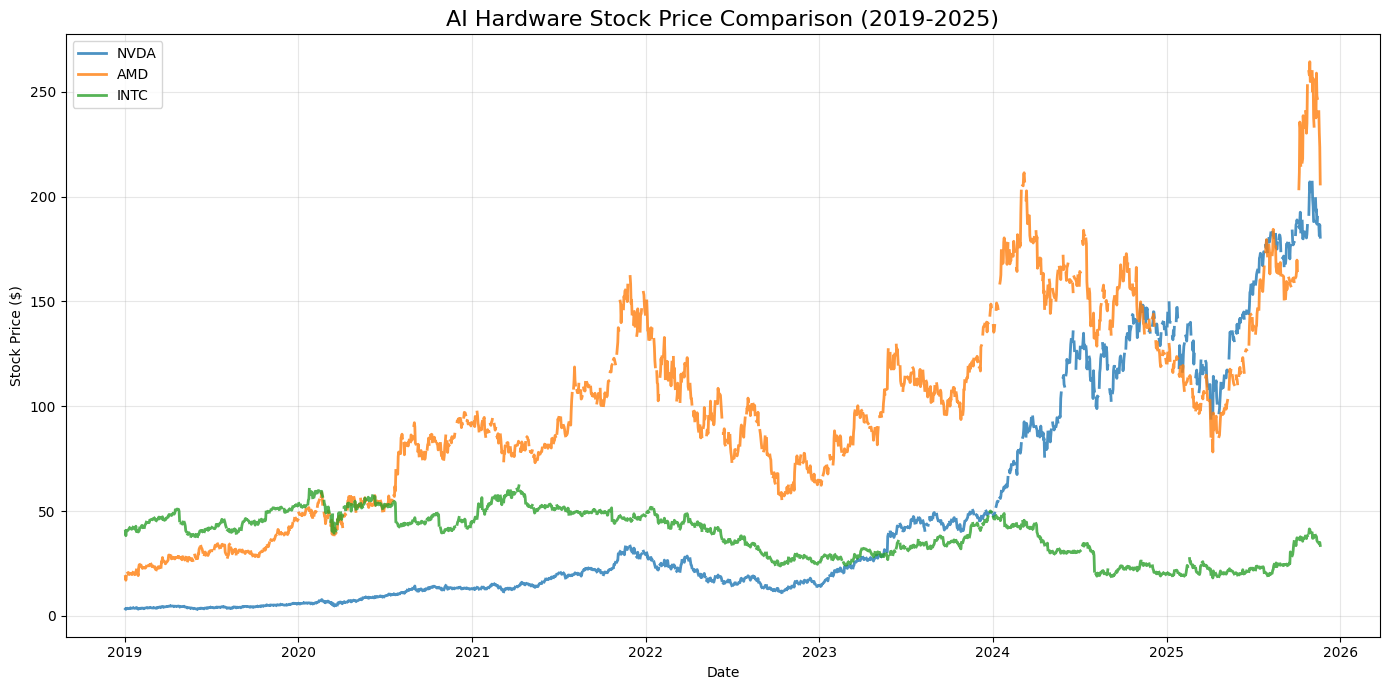


Cumulative Returns (%) - AI Hardware:
NVDA: 5248.57%
AMD: 994.11%
INTC: -17.02%


In [48]:
# Comparative Stock Price Trends - AI Hardware (NVDA, AMD, INTC)
plt.figure(figsize=(14, 7))
for stock in ai_hardware:
    if stock in df.columns:
        plt.plot(df.index, df[stock], label=stock, linewidth=2, alpha=0.8)

plt.title("AI Hardware Stock Price Comparison (2019-2025)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate and display cumulative returns
print("\nCumulative Returns (%) - AI Hardware:")
for stock in ai_hardware:
    if stock in df.columns and df[stock].notna().sum() > 0:
        start_price = df[stock].dropna().iloc[0]
        end_price = df[stock].dropna().iloc[-1]
        cum_return = ((end_price - start_price) / start_price) * 100
        print(f"{stock}: {cum_return:.2f}%")

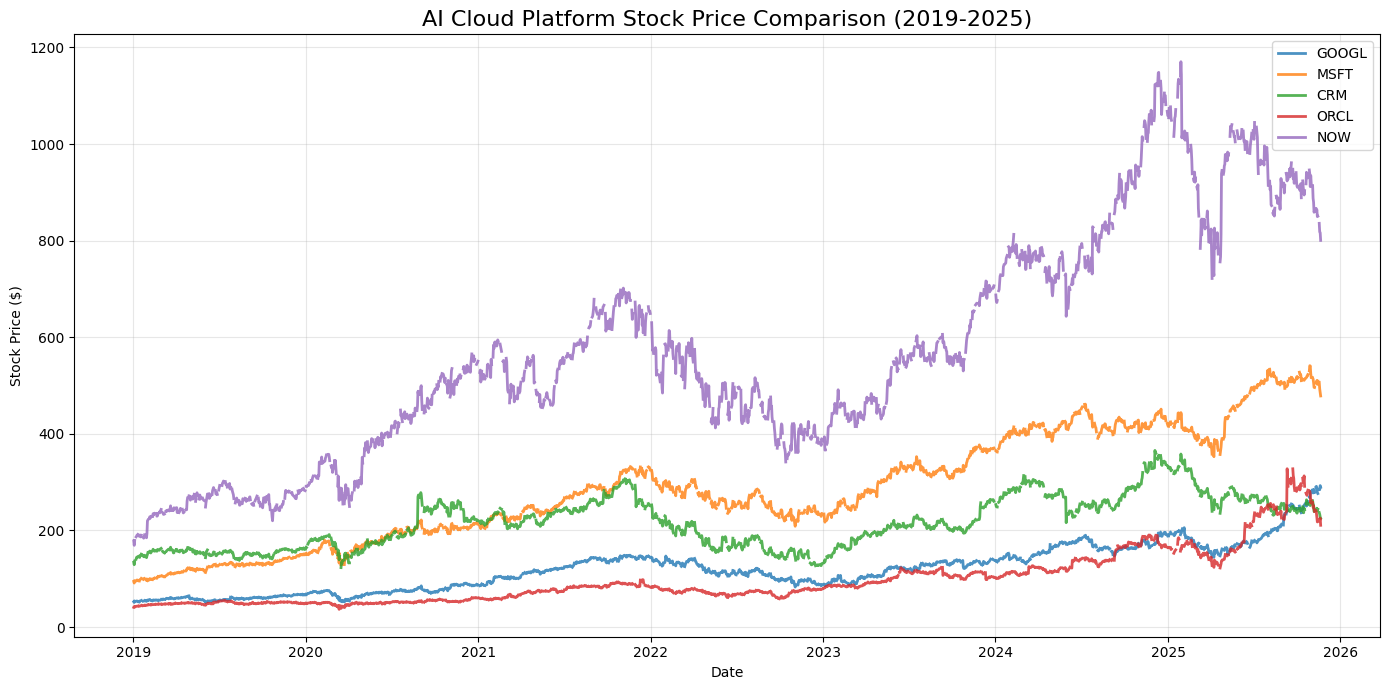


Cumulative Returns (%) - AI Cloud:
GOOGL: 452.67%
MSFT: 405.67%
CRM: 68.01%
ORCL: 416.97%
NOW: 348.89%


In [49]:
# Comparative Stock Price Trends - AI Cloud Platforms
plt.figure(figsize=(14, 7))
for stock in ai_cloud:
    if stock in df.columns:
        plt.plot(df.index, df[stock], label=stock, linewidth=2, alpha=0.8)

plt.title("AI Cloud Platform Stock Price Comparison (2019-2025)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Cumulative returns
print("\nCumulative Returns (%) - AI Cloud:")
for stock in ai_cloud:
    if stock in df.columns and df[stock].notna().sum() > 0:
        start_price = df[stock].dropna().iloc[0]
        end_price = df[stock].dropna().iloc[-1]
        cum_return = ((end_price - start_price) / start_price) * 100
        print(f"{stock}: {cum_return:.2f}%")

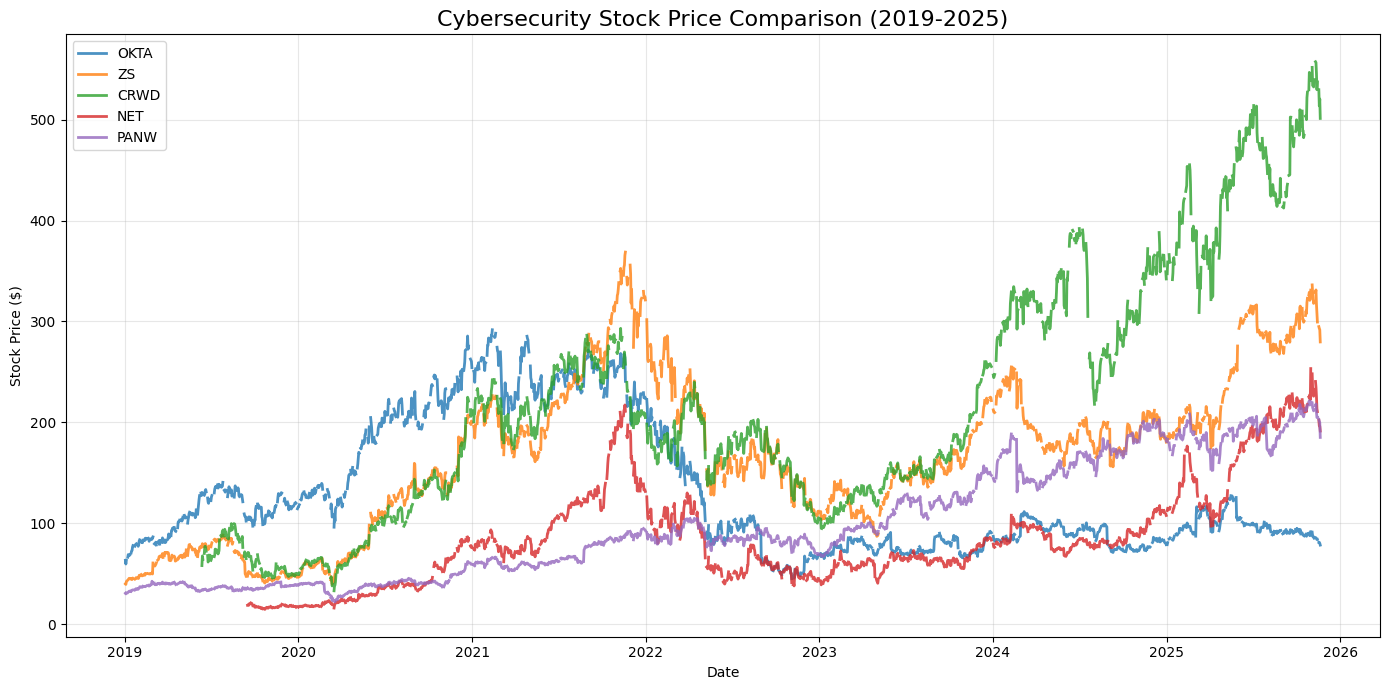


Cumulative Returns (%) - Cybersecurity:
OKTA: 23.81%
ZS: 602.66%
CRWD: 764.33%
NET: 963.28%
PANW: 506.09%


In [50]:
# Comparative Stock Price Trends - Cybersecurity
plt.figure(figsize=(14, 7))
for stock in cybersecurity:
    if stock in df.columns:
        plt.plot(df.index, df[stock], label=stock, linewidth=2, alpha=0.8)

plt.title("Cybersecurity Stock Price Comparison (2019-2025)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Cumulative returns
print("\nCumulative Returns (%) - Cybersecurity:")
for stock in cybersecurity:
    if stock in df.columns and df[stock].notna().sum() > 0:
        start_price = df[stock].dropna().iloc[0]
        end_price = df[stock].dropna().iloc[-1]
        cum_return = ((end_price - start_price) / start_price) * 100
        print(f"{stock}: {cum_return:.2f}%")

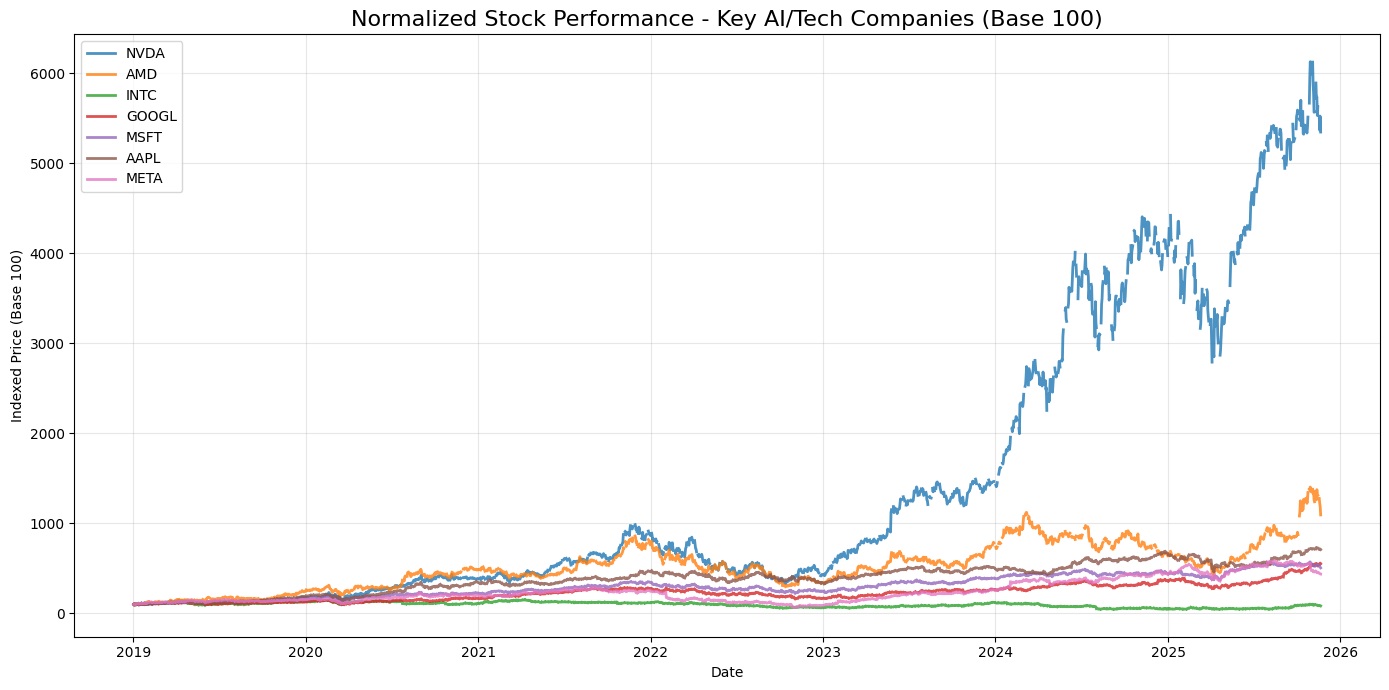

In [51]:
# Normalized Stock Price Comparison (Indexed to 100)
# This allows better comparison of relative performance across different price levels
plt.figure(figsize=(14, 7))

all_stocks = ai_hardware + ['GOOGL', 'MSFT', 'AAPL', 'META']
colors = plt.cm.tab10(range(len(all_stocks)))

for idx, stock in enumerate(all_stocks):
    if stock in df.columns and df[stock].notna().sum() > 0:
        normalized = (df[stock] / df[stock].dropna().iloc[0]) * 100
        plt.plot(df.index, normalized, label=stock, linewidth=2, alpha=0.8, color=colors[idx])

plt.title("Normalized Stock Performance - Key AI/Tech Companies (Base 100)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Indexed Price (Base 100)")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Time Series Analysis - Market Indices & Volatility

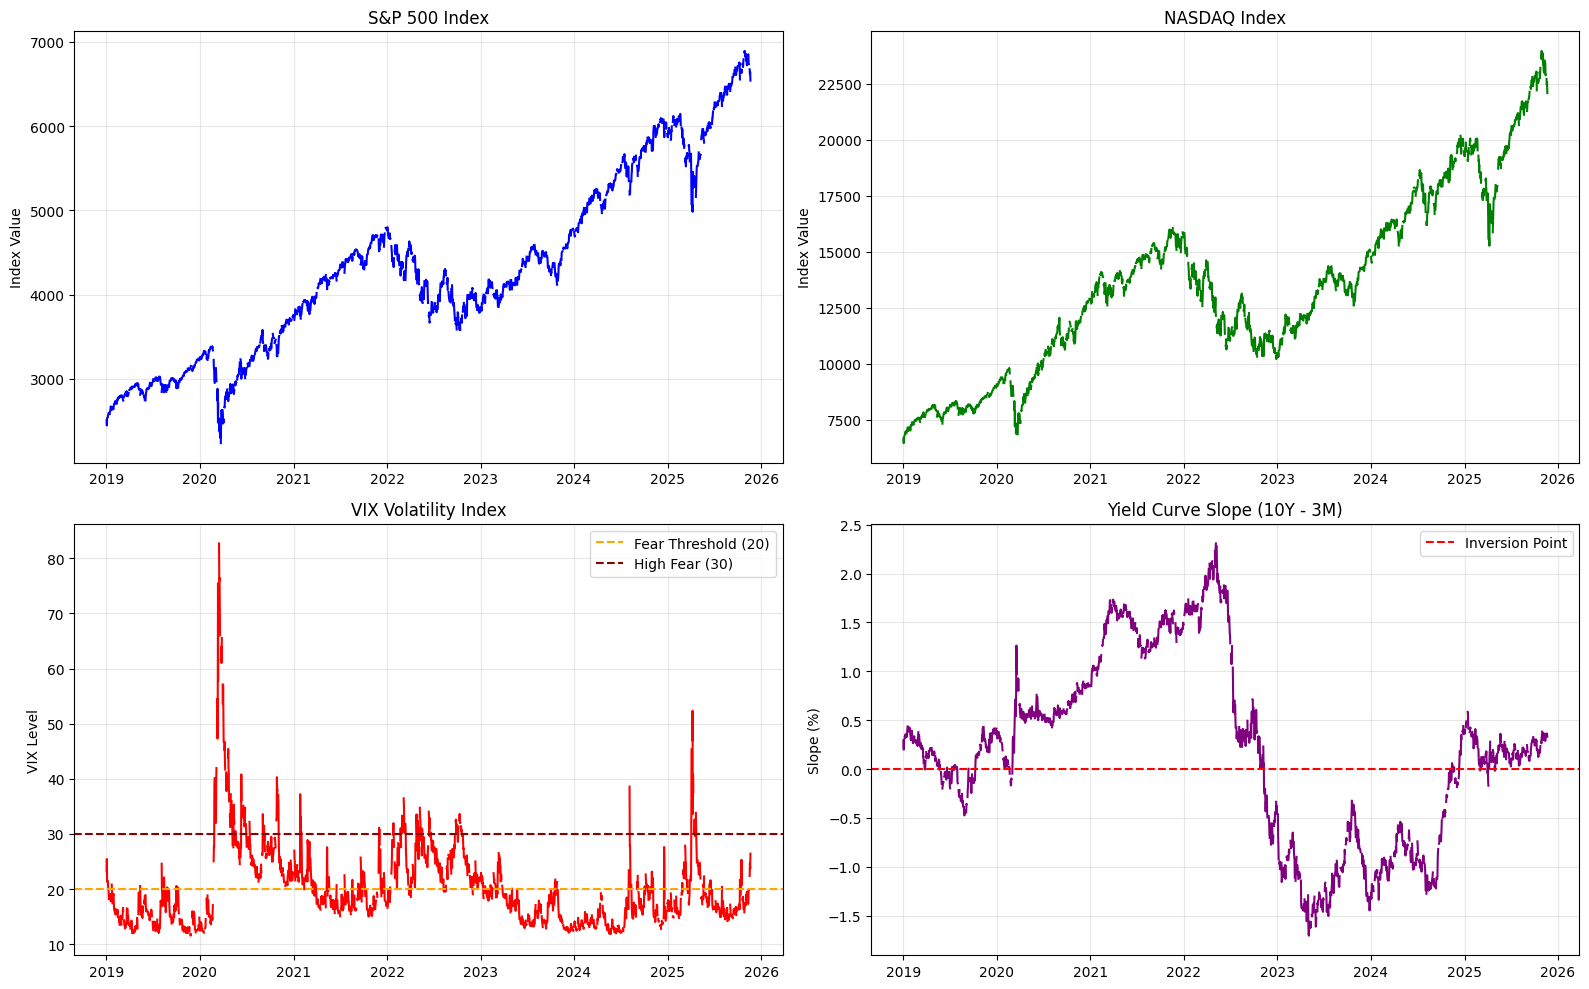

In [52]:
# Market Indices Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# SP500
axes[0, 0].plot(df.index, df['SP500'], color='blue', linewidth=1.5)
axes[0, 0].set_title('S&P 500 Index', fontsize=12)
axes[0, 0].set_ylabel('Index Value')
axes[0, 0].grid(True, alpha=0.3)

# NASDAQ
axes[0, 1].plot(df.index, df['NASDAQ'], color='green', linewidth=1.5)
axes[0, 1].set_title('NASDAQ Index', fontsize=12)
axes[0, 1].set_ylabel('Index Value')
axes[0, 1].grid(True, alpha=0.3)

# VIX (Volatility)
axes[1, 0].plot(df.index, df['VIX'], color='red', linewidth=1.5)
axes[1, 0].axhline(y=20, color='orange', linestyle='--', label='Fear Threshold (20)')
axes[1, 0].axhline(y=30, color='darkred', linestyle='--', label='High Fear (30)')
axes[1, 0].set_title('VIX Volatility Index', fontsize=12)
axes[1, 0].set_ylabel('VIX Level')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Yield Curve
axes[1, 1].plot(df.index, df['Yield_Curve_Slope'], color='purple', linewidth=1.5)
axes[1, 1].axhline(y=0, color='red', linestyle='--', label='Inversion Point')
axes[1, 1].set_title('Yield Curve Slope (10Y - 3M)', fontsize=12)
axes[1, 1].set_ylabel('Slope (%)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

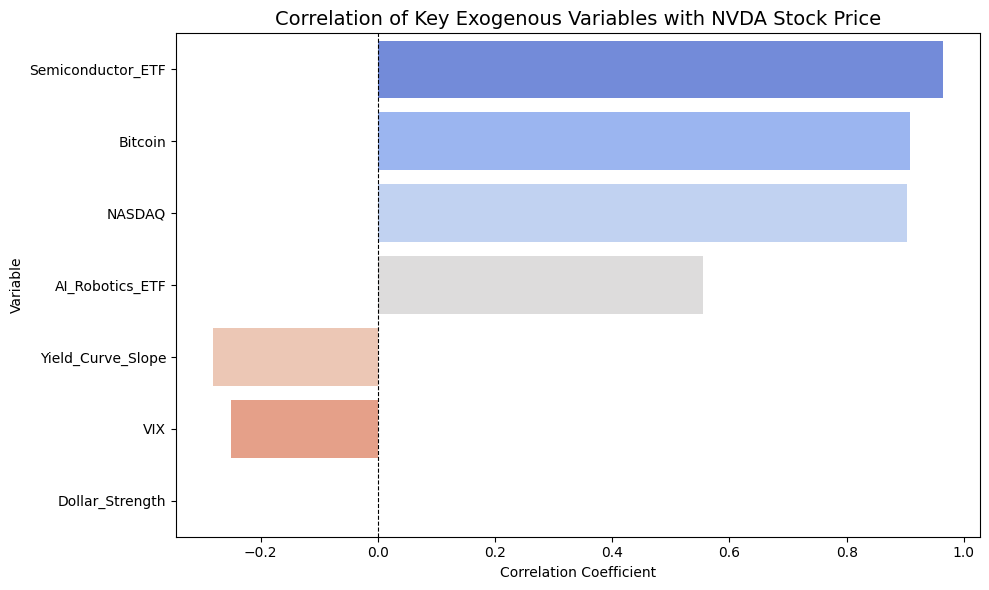


Correlation Values:
            Variable  Correlation with NVDA
4  Semiconductor_ETF               0.965205
2            Bitcoin               0.908956
6             NASDAQ               0.903802
5    AI_Robotics_ETF               0.554508
1  Yield_Curve_Slope              -0.282238
0                VIX              -0.250384
3    Dollar_Strength                    NaN


In [53]:
# Correlation Between Key Exogenous Variables and NVDA (AI Leader)
exog_vars = ['VIX', 'Yield_Curve_Slope', 'Bitcoin', 'Dollar_Strength', 
             'Semiconductor_ETF', 'AI_Robotics_ETF', 'NASDAQ']

correlations = {}
for var in exog_vars:
    if var in df.columns and 'NVDA' in df.columns:
        corr = df[['NVDA', var]].dropna().corr().iloc[0, 1]
        correlations[var] = corr

# Sort and display
corr_df = pd.DataFrame(list(correlations.items()), columns=['Variable', 'Correlation with NVDA'])
corr_df = corr_df.sort_values('Correlation with NVDA', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Correlation with NVDA', y='Variable', data=corr_df, palette='coolwarm')
plt.title("Correlation of Key Exogenous Variables with NVDA Stock Price", fontsize=14)
plt.xlabel("Correlation Coefficient")
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

print("\nCorrelation Values:")
print(corr_df)

### Multivariate Analysis - Sector Correlations & Regime Analysis

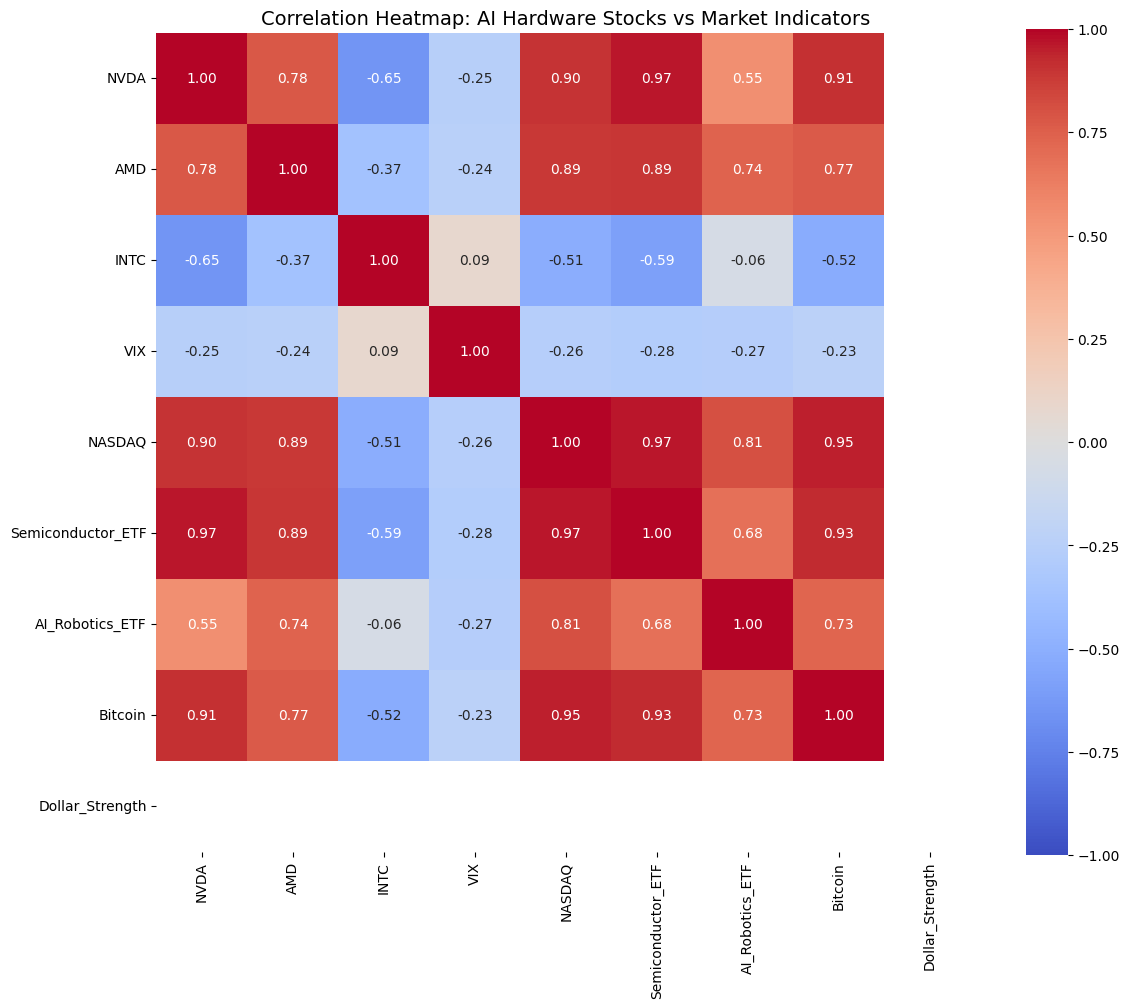

In [54]:
# Correlation Heatmap - AI Hardware Stocks vs Key Market Indicators
analysis_cols = ['NVDA', 'AMD', 'INTC', 'VIX', 'NASDAQ', 'Semiconductor_ETF', 
                 'AI_Robotics_ETF', 'Bitcoin', 'Dollar_Strength']

corr_matrix = df[analysis_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', 
            center=0, vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap: AI Hardware Stocks vs Market Indicators", fontsize=14)
plt.tight_layout()
plt.show()

In [55]:
# Create Sector Indices (average stock price per sector)
df['AI_Hardware_Index'] = df[[col for col in ai_hardware if col in df.columns]].mean(axis=1)
df['AI_Cloud_Index'] = df[[col for col in ai_cloud if col in df.columns]].mean(axis=1)
df['Cybersecurity_Index'] = df[[col for col in cybersecurity if col in df.columns]].mean(axis=1)
df['Big_Tech_Index'] = df[[col for col in big_tech if col in df.columns]].mean(axis=1)
df['Software_Index'] = df[[col for col in software if col in df.columns]].mean(axis=1)

# Calculate sector returns
df['AI_Hardware_Return'] = df['AI_Hardware_Index'].pct_change() * 100
df['AI_Cloud_Return'] = df['AI_Cloud_Index'].pct_change() * 100
df['Cybersecurity_Return'] = df['Cybersecurity_Index'].pct_change() * 100
df['Big_Tech_Return'] = df['Big_Tech_Index'].pct_change() * 100
df['Software_Return'] = df['Software_Index'].pct_change() * 100

print("Sector indices created successfully")
print("\nSector Statistics:")
for sector in ['AI_Hardware_Index', 'AI_Cloud_Index', 'Cybersecurity_Index', 'Big_Tech_Index', 'Software_Index']:
    if sector in df.columns:
        start = df[sector].dropna().iloc[0]
        end = df[sector].dropna().iloc[-1]
        cum_return = ((end - start) / start) * 100
        print(f"{sector.replace('_Index', '')}: {cum_return:.2f}% cumulative return")

Sector indices created successfully

Sector Statistics:
AI_Hardware: 570.03% cumulative return
AI_Cloud: 300.72% cumulative return
Cybersecurity: 454.99% cumulative return
Big_Tech: 312.34% cumulative return
Software: 111.27% cumulative return


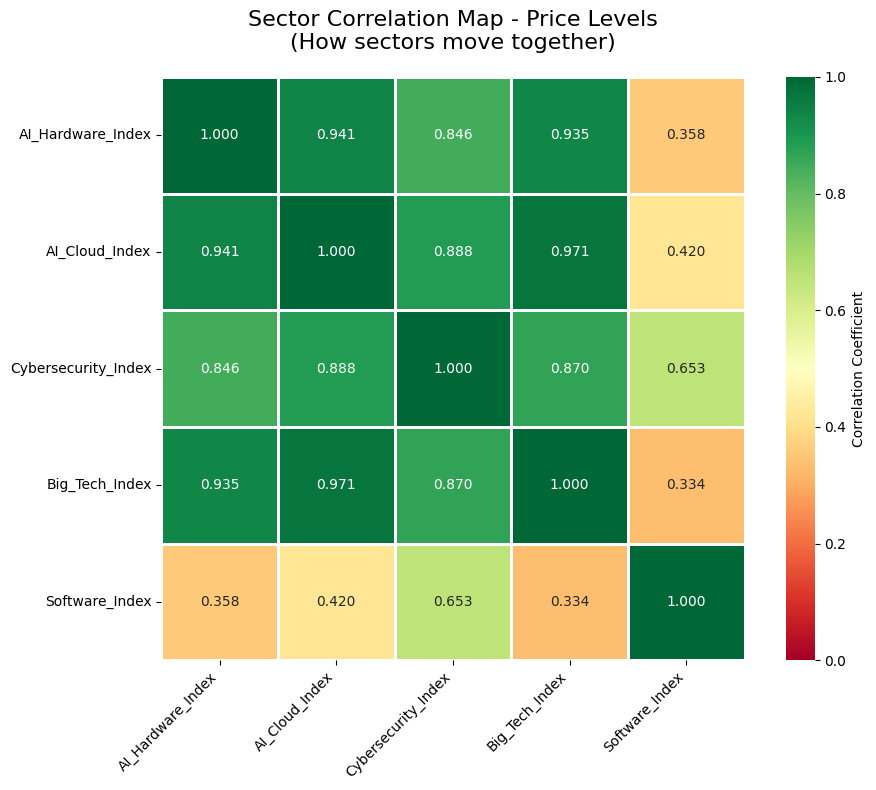


Interpretation:
- Values close to 1.0: Sectors move in lockstep (high correlation)
- Values around 0.5-0.8: Moderate correlation
- Values below 0.5: Sectors behave independently


In [56]:
# Sector Price Level Correlation Heatmap
sector_price_cols = ['AI_Hardware_Index', 'AI_Cloud_Index', 'Cybersecurity_Index', 
                     'Big_Tech_Index', 'Software_Index']

sector_price_corr = df[sector_price_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(sector_price_corr, annot=True, cmap='RdYlGn', fmt='.3f', 
            center=0.5, vmin=0, vmax=1, square=True, linewidths=1,
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Sector Correlation Map - Price Levels\n(How sectors move together)", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Values close to 1.0: Sectors move in lockstep (high correlation)")
print("- Values around 0.5-0.8: Moderate correlation")
print("- Values below 0.5: Sectors behave independently")

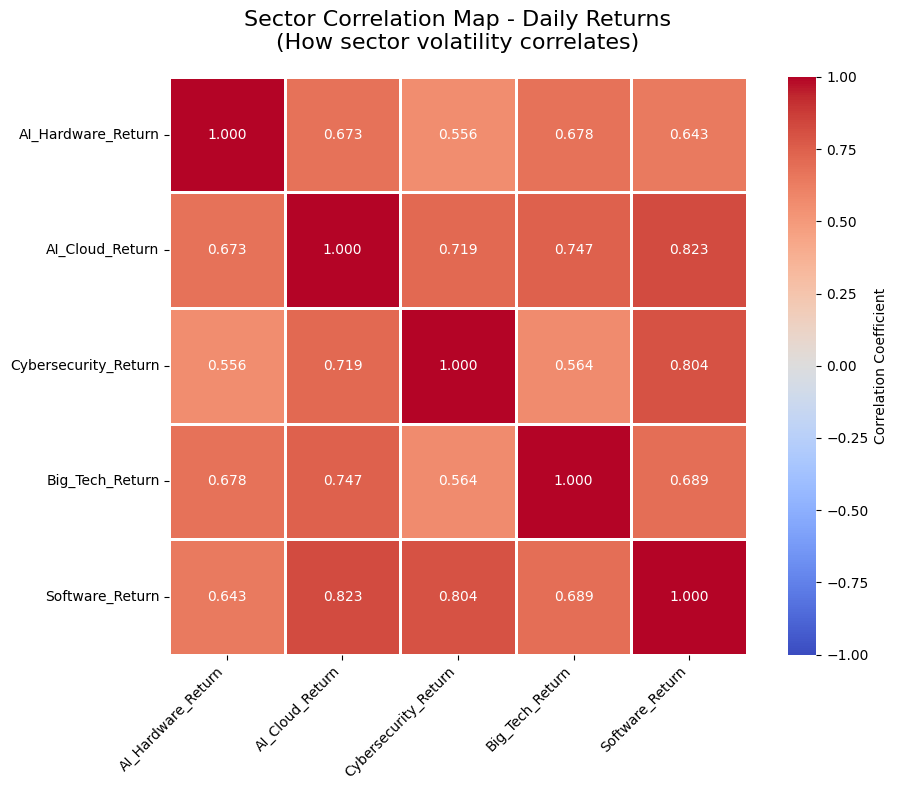


Interpretation:
- High positive correlation: Sectors react to market events similarly
- Low/negative correlation: Sectors provide diversification benefits
- This map is crucial for understanding sector co-movement in your SARIMAX model


In [57]:
# Sector Returns Correlation Heatmap (Better for SARIMAX modeling)
sector_return_cols = ['AI_Hardware_Return', 'AI_Cloud_Return', 'Cybersecurity_Return', 
                      'Big_Tech_Return', 'Software_Return']

sector_return_corr = df[sector_return_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(sector_return_corr, annot=True, cmap='coolwarm', fmt='.3f', 
            center=0, vmin=-1, vmax=1, square=True, linewidths=1,
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Sector Correlation Map - Daily Returns\n(How sector volatility correlates)", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- High positive correlation: Sectors react to market events similarly")
print("- Low/negative correlation: Sectors provide diversification benefits")
print("- This map is crucial for understanding sector co-movement in your SARIMAX model")

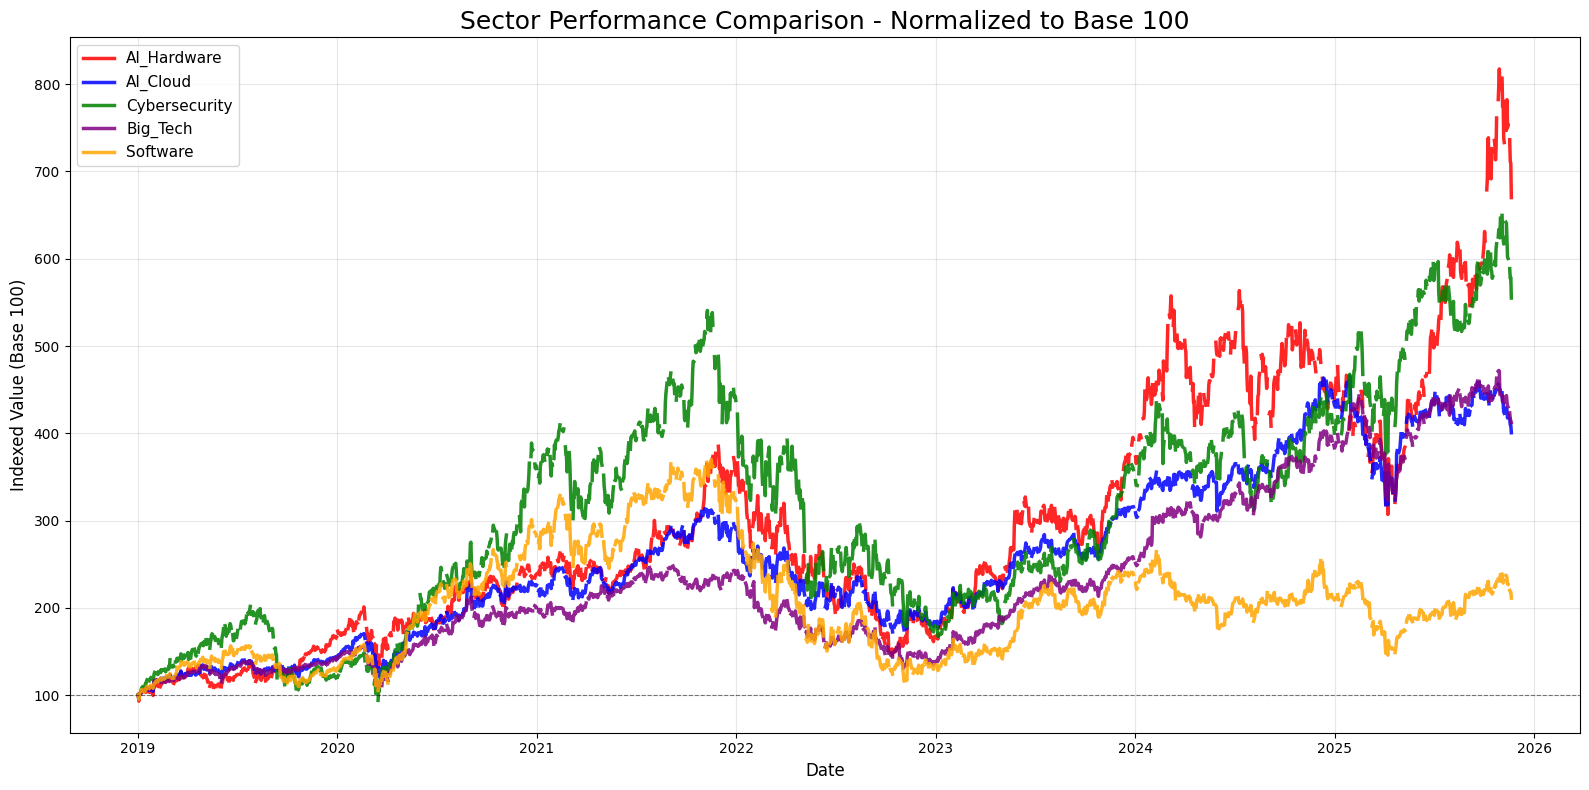


Sector Performance Ranking (Cumulative Returns):
1. AI_Hardware: 570.03%
2. Cybersecurity: 454.99%
3. Big_Tech: 312.34%
4. AI_Cloud: 300.72%
5. Software: 111.27%


In [58]:
# Sector Behavior Over Time - Comparative Performance
plt.figure(figsize=(16, 8))

# Normalize each sector to base 100 for comparison
for sector, color in zip(['AI_Hardware_Index', 'AI_Cloud_Index', 'Cybersecurity_Index', 
                          'Big_Tech_Index', 'Software_Index'],
                         ['red', 'blue', 'green', 'purple', 'orange']):
    if sector in df.columns and df[sector].notna().sum() > 0:
        normalized = (df[sector] / df[sector].dropna().iloc[0]) * 100
        plt.plot(df.index, normalized, label=sector.replace('_Index', ''), 
                linewidth=2.5, alpha=0.85, color=color)

plt.title("Sector Performance Comparison - Normalized to Base 100", fontsize=18)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Indexed Value (Base 100)", fontsize=12)
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3)
plt.axhline(y=100, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
plt.tight_layout()
plt.show()

print("\nSector Performance Ranking (Cumulative Returns):")
sector_performance = {}
for sector in ['AI_Hardware_Index', 'AI_Cloud_Index', 'Cybersecurity_Index', 
               'Big_Tech_Index', 'Software_Index']:
    if sector in df.columns and df[sector].notna().sum() > 0:
        start = df[sector].dropna().iloc[0]
        end = df[sector].dropna().iloc[-1]
        cum_return = ((end - start) / start) * 100
        sector_performance[sector.replace('_Index', '')] = cum_return

sorted_sectors = sorted(sector_performance.items(), key=lambda x: x[1], reverse=True)
for i, (sector, perf) in enumerate(sorted_sectors, 1):
    print(f"{i}. {sector}: {perf:.2f}%")

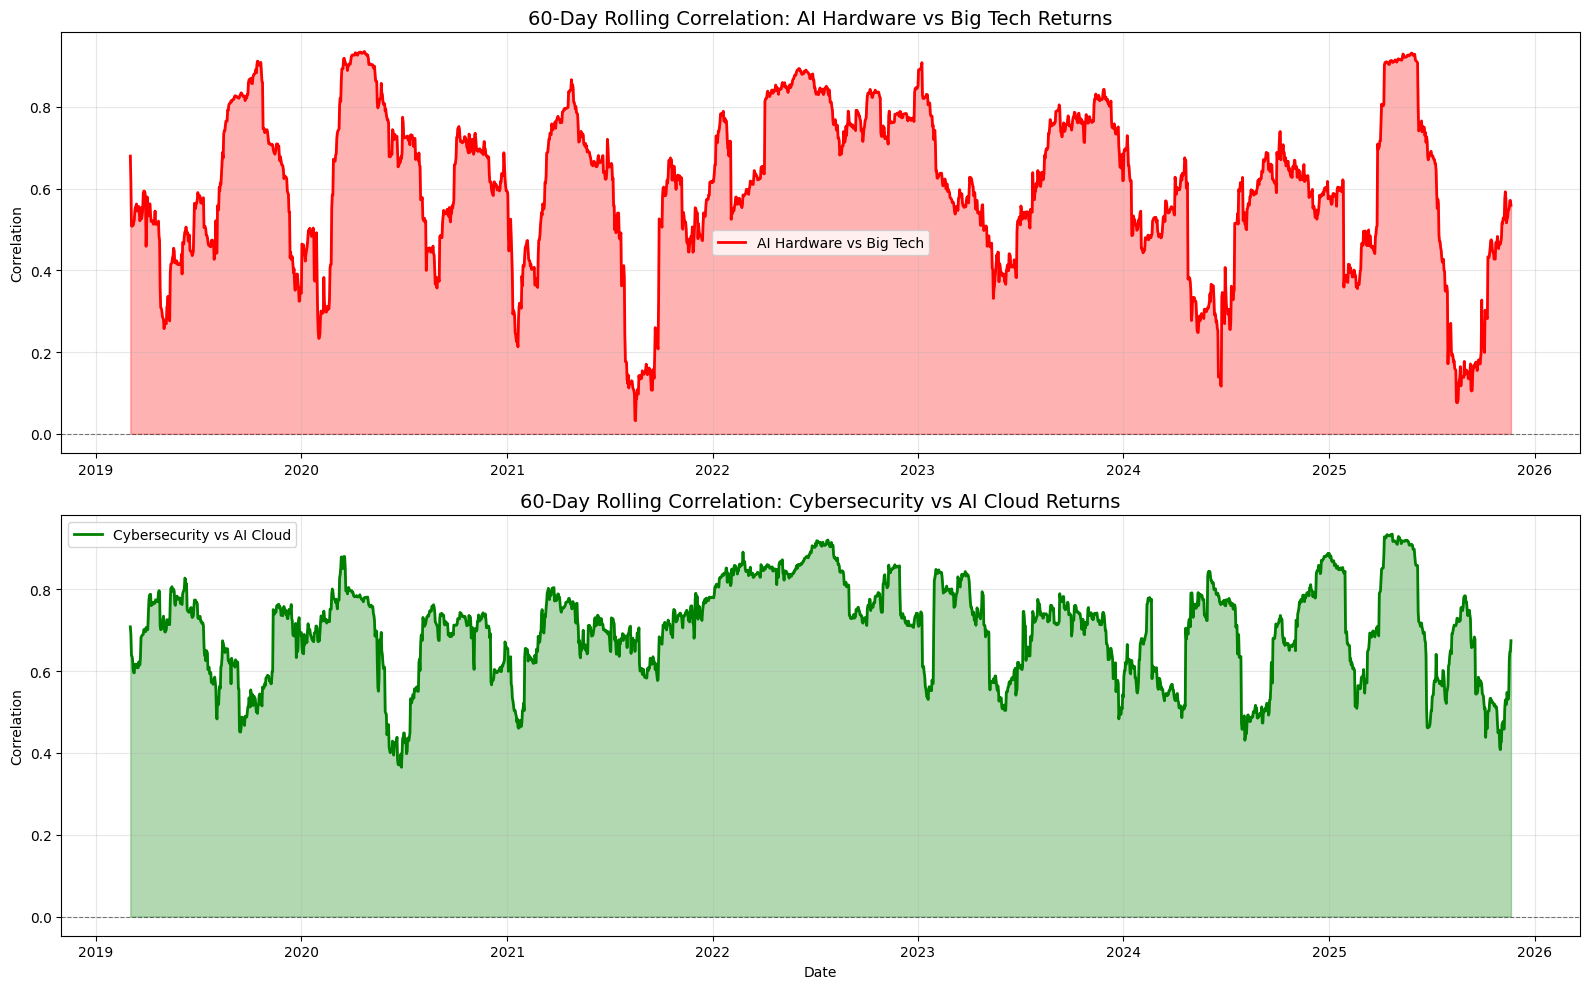


Insight: Rolling correlations reveal when sectors decouple or move together.
This is critical for understanding regime changes in your SARIMAX model.


In [59]:
# Rolling Correlation Between Sectors Over Time
# Shows how sector relationships change during different market conditions

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# AI Hardware vs Big Tech
rolling_corr_hw_tech = df['AI_Hardware_Return'].rolling(window=60).corr(df['Big_Tech_Return'])
axes[0].plot(df.index, rolling_corr_hw_tech, linewidth=2, color='red', label='AI Hardware vs Big Tech')
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0].fill_between(df.index, 0, rolling_corr_hw_tech, alpha=0.3, color='red')
axes[0].set_title('60-Day Rolling Correlation: AI Hardware vs Big Tech Returns', fontsize=14)
axes[0].set_ylabel('Correlation')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Cybersecurity vs AI Cloud
rolling_corr_cyber_cloud = df['Cybersecurity_Return'].rolling(window=60).corr(df['AI_Cloud_Return'])
axes[1].plot(df.index, rolling_corr_cyber_cloud, linewidth=2, color='green', label='Cybersecurity vs AI Cloud')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1].fill_between(df.index, 0, rolling_corr_cyber_cloud, alpha=0.3, color='green')
axes[1].set_title('60-Day Rolling Correlation: Cybersecurity vs AI Cloud Returns', fontsize=14)
axes[1].set_ylabel('Correlation')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nInsight: Rolling correlations reveal when sectors decouple or move together.")
print("This is critical for understanding regime changes in your SARIMAX model.")

In [60]:
# Create Aggregated AI Tech Index (Equal-Weighted Portfolio)
# This will be the target variable for SARIMAX forecasting
all_tech_stocks = ai_hardware + ai_cloud + cybersecurity + big_tech + software

# Calculate equal-weighted index
df['AI_Tech_Index'] = df[[col for col in all_tech_stocks if col in df.columns]].mean(axis=1)

# Normalize to base 100
first_valid = df['AI_Tech_Index'].dropna().iloc[0]
df['AI_Tech_Index_Normalized'] = (df['AI_Tech_Index'] / first_valid) * 100

# Calculate index returns
df['AI_Tech_Index_Return'] = df['AI_Tech_Index'].pct_change() * 100

print(f"AI Tech Index Created - Using {len([col for col in all_tech_stocks if col in df.columns])} stocks")
print(f"\nIndex Statistics:")
print(df['AI_Tech_Index'].describe())

AI Tech Index Created - Using 24 stocks

Index Statistics:
count    1733.000000
mean      171.827053
std        55.834278
min        69.877663
25%       122.467175
50%       171.484707
75%       216.831368
max       297.028521
Name: AI_Tech_Index, dtype: float64


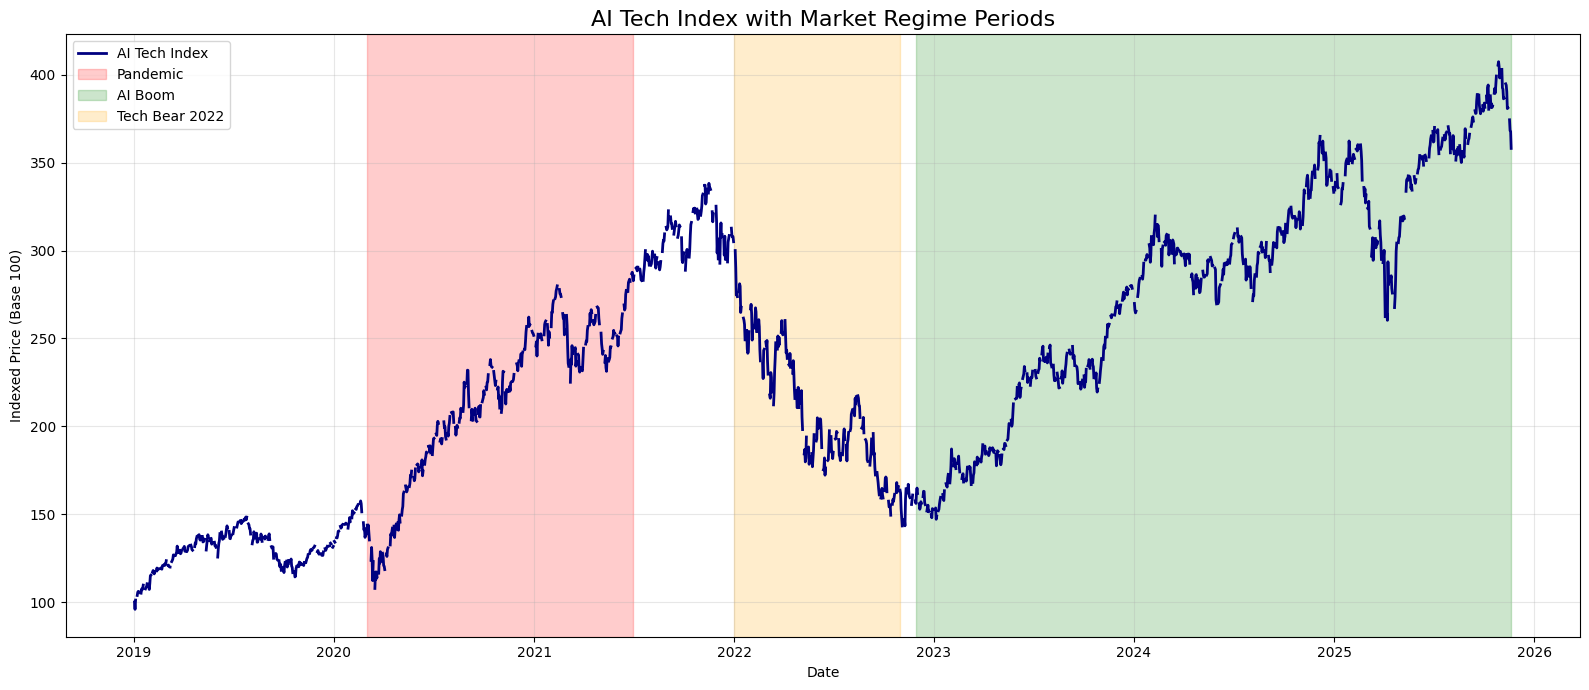

In [61]:
# Plot AI Tech Index with Regime Periods
fig, ax = plt.subplots(figsize=(16, 7))

ax.plot(df.index, df['AI_Tech_Index_Normalized'], linewidth=2, color='navy', label='AI Tech Index')

# Highlight regime periods
if 'Pandemic_Period' in df.columns:
    pandemic = df[df['Pandemic_Period'] == 1]
    if len(pandemic) > 0:
        ax.axvspan(pandemic.index.min(), pandemic.index.max(), alpha=0.2, color='red', label='Pandemic')

if 'AI_Boom_Period' in df.columns:
    ai_boom = df[df['AI_Boom_Period'] == 1]
    if len(ai_boom) > 0:
        ax.axvspan(ai_boom.index.min(), ai_boom.index.max(), alpha=0.2, color='green', label='AI Boom')

if 'Tech_Bear_2022' in df.columns:
    bear = df[df['Tech_Bear_2022'] == 1]
    if len(bear) > 0:
        ax.axvspan(bear.index.min(), bear.index.max(), alpha=0.2, color='orange', label='Tech Bear 2022')

ax.set_title('AI Tech Index with Market Regime Periods', fontsize=16)
ax.set_xlabel('Date')
ax.set_ylabel('Indexed Price (Base 100)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

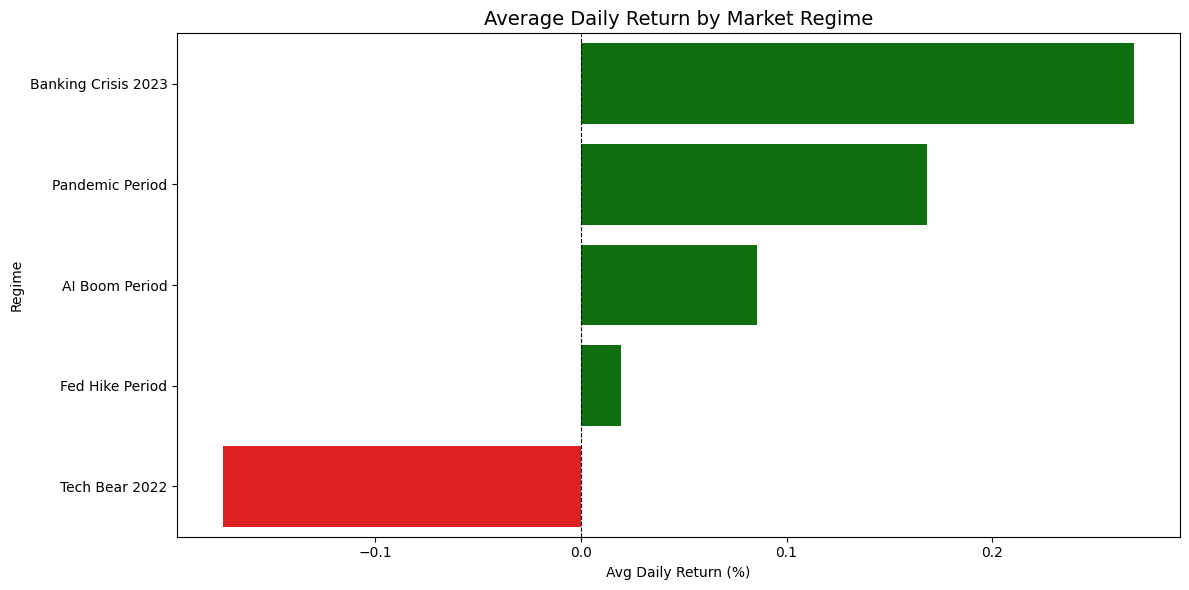


Regime Performance Summary:
                Regime  Avg Daily Return (%)
4  Banking Crisis 2023              0.269082
0      Pandemic Period              0.168451
1       AI Boom Period              0.085841
2      Fed Hike Period              0.019329
3       Tech Bear 2022             -0.174077


In [62]:
# Monthly Average Performance by Regime
regime_cols = ['Pandemic_Period', 'AI_Boom_Period', 'Fed_Hike_Period', 
               'Tech_Bear_2022', 'Banking_Crisis_2023']

regime_performance = {}
for regime in regime_cols:
    if regime in df.columns:
        avg_return = df[df[regime] == 1]['AI_Tech_Index_Return'].mean()
        regime_performance[regime.replace('_', ' ')] = avg_return

regime_df = pd.DataFrame(list(regime_performance.items()), 
                         columns=['Regime', 'Avg Daily Return (%)'])
regime_df = regime_df.sort_values('Avg Daily Return (%)', ascending=False)

plt.figure(figsize=(12, 6))
colors = ['green' if x > 0 else 'red' for x in regime_df['Avg Daily Return (%)']]
sns.barplot(x='Avg Daily Return (%)', y='Regime', data=regime_df, palette=colors)
plt.title('Average Daily Return by Market Regime', fontsize=14)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

print("\nRegime Performance Summary:")
print(regime_df)

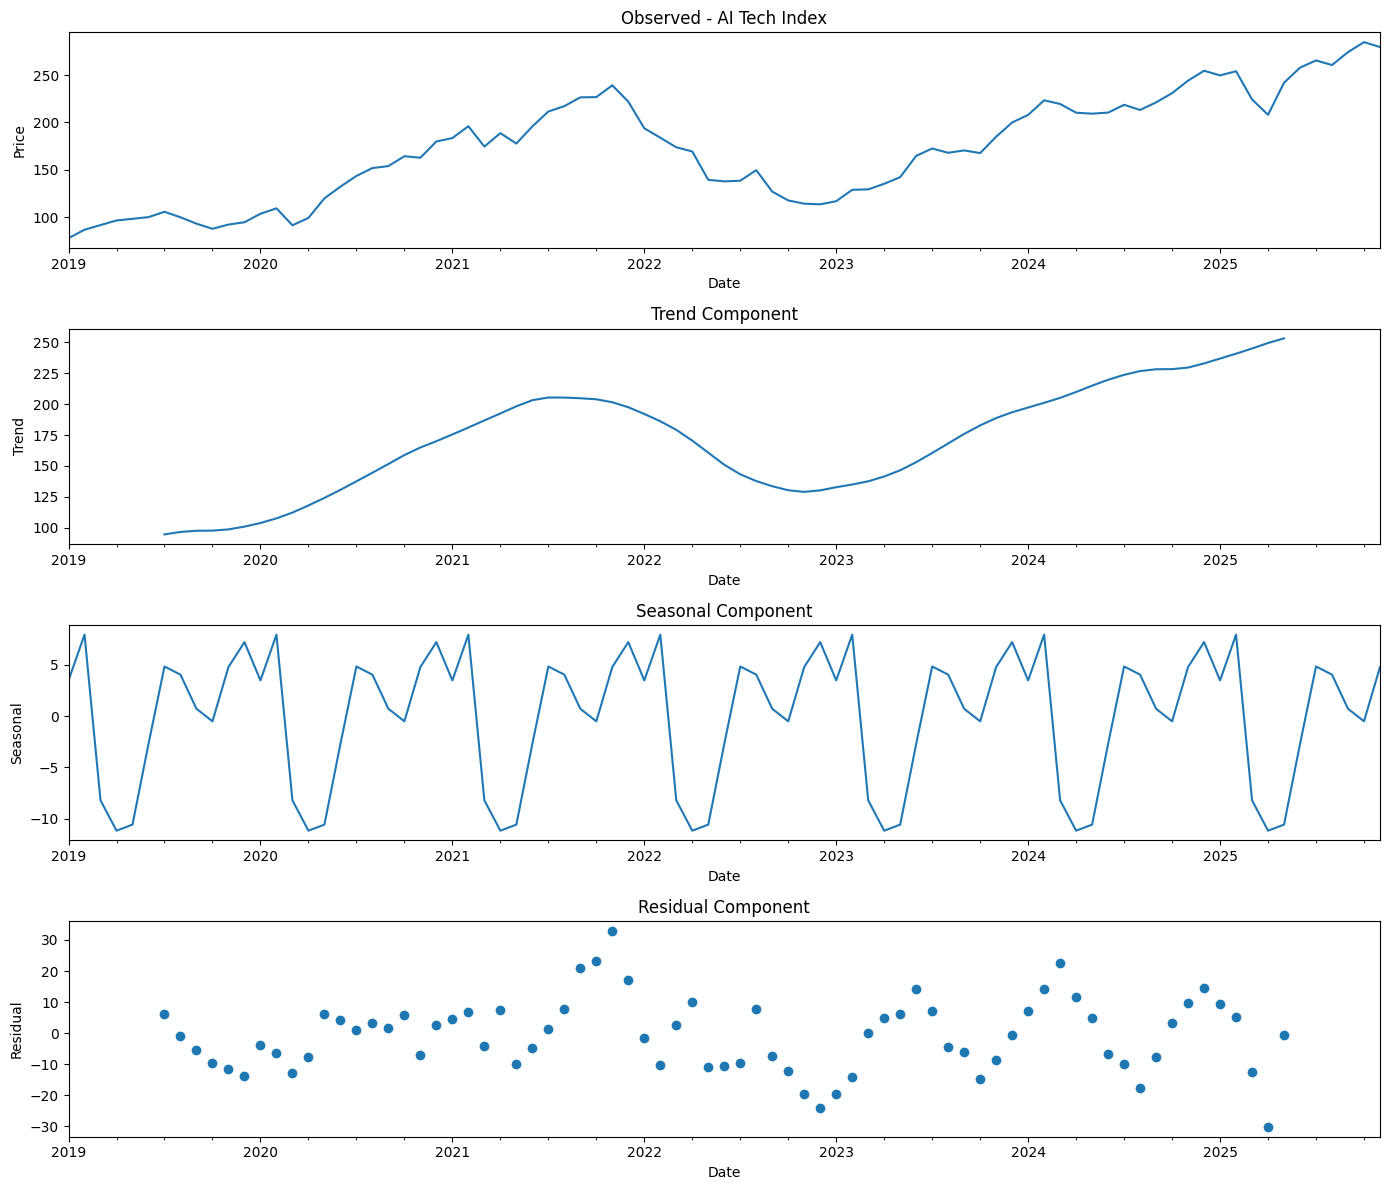

Seasonal decomposition complete


In [63]:
# Seasonal Decomposition of AI Tech Index
from statsmodels.tsa.seasonal import seasonal_decompose

# Resample to monthly for better decomposition
monthly_index = df['AI_Tech_Index'].resample('M').mean().dropna()

if len(monthly_index) > 24:  # Need at least 2 years
    decomposition = seasonal_decompose(monthly_index, model='additive', period=12)
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    
    decomposition.observed.plot(ax=axes[0], title="Observed - AI Tech Index")
    axes[0].set_ylabel('Price')
    
    decomposition.trend.plot(ax=axes[1], title="Trend Component")
    axes[1].set_ylabel('Trend')
    
    decomposition.seasonal.plot(ax=axes[2], title="Seasonal Component")
    axes[2].set_ylabel('Seasonal')
    
    decomposition.resid.plot(ax=axes[3], title="Residual Component", marker='o', linestyle='None')
    axes[3].set_ylabel('Residual')
    axes[3].set_xlabel('Date')
    
    plt.tight_layout()
    plt.show()
    
    print("Seasonal decomposition complete")
else:
    print("Not enough data for seasonal decomposition")

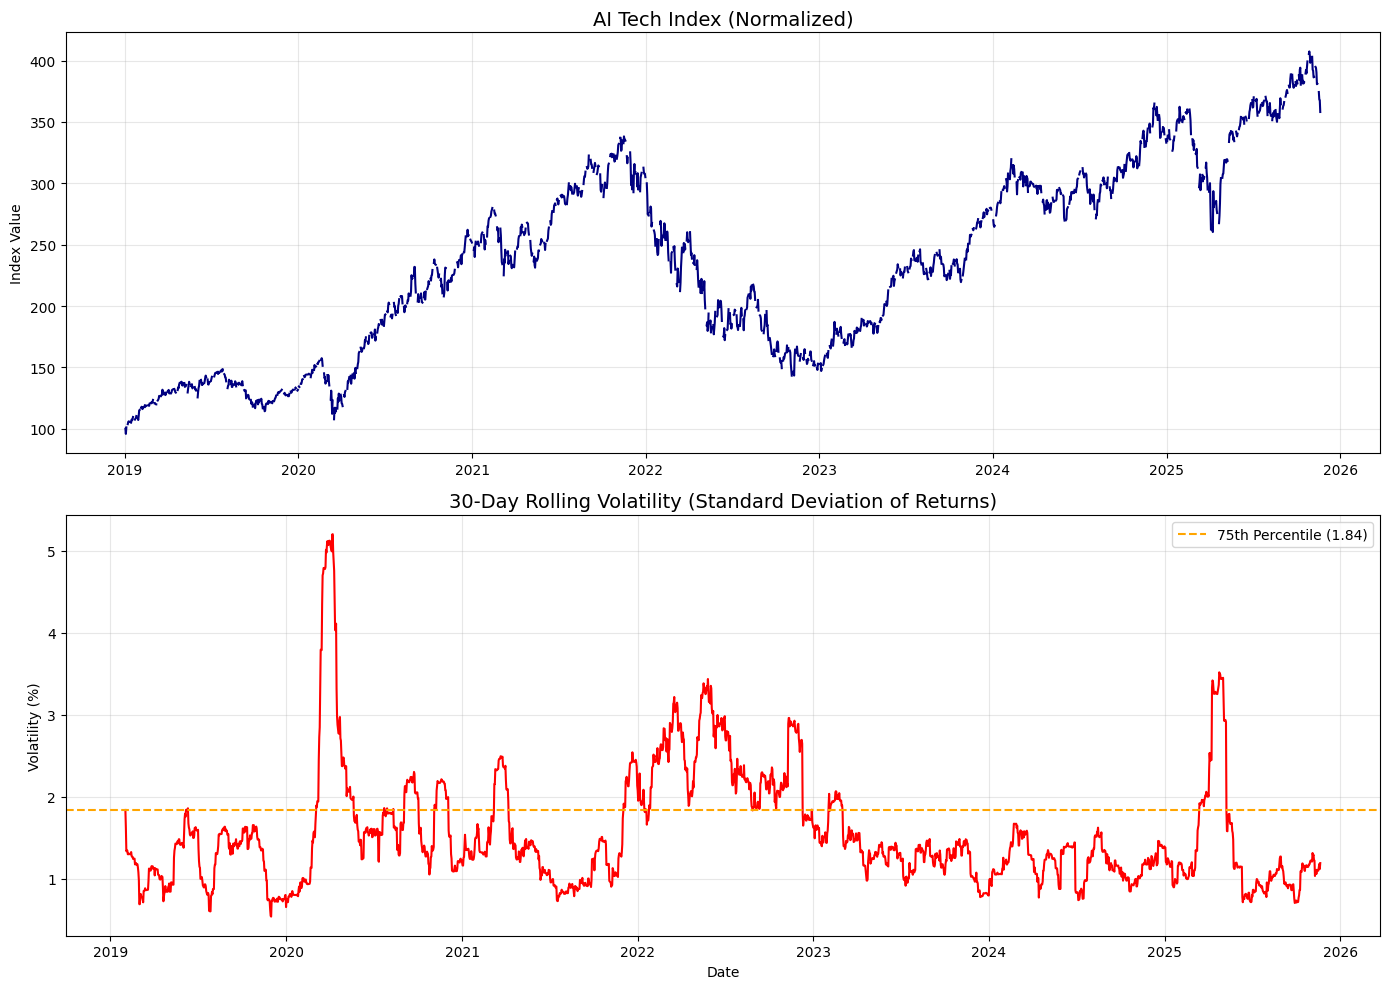

In [64]:
# Rolling Volatility Analysis (30-day window)
df['AI_Tech_Volatility_30d'] = df['AI_Tech_Index_Return'].rolling(window=30).std()

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Index Price
axes[0].plot(df.index, df['AI_Tech_Index_Normalized'], linewidth=1.5, color='navy')
axes[0].set_title('AI Tech Index (Normalized)', fontsize=14)
axes[0].set_ylabel('Index Value')
axes[0].grid(True, alpha=0.3)

# Rolling Volatility
axes[1].plot(df.index, df['AI_Tech_Volatility_30d'], linewidth=1.5, color='red')
axes[1].set_title('30-Day Rolling Volatility (Standard Deviation of Returns)', fontsize=14)
axes[1].set_ylabel('Volatility (%)')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=0.3)

# Highlight high volatility periods
high_vol_threshold = df['AI_Tech_Volatility_30d'].quantile(0.75)
axes[1].axhline(y=high_vol_threshold, color='orange', linestyle='--', 
                label=f'75th Percentile ({high_vol_threshold:.2f})')
axes[1].legend()

plt.tight_layout()
plt.show()

### Exogenous Variable Analysis for SARIMAX Modeling

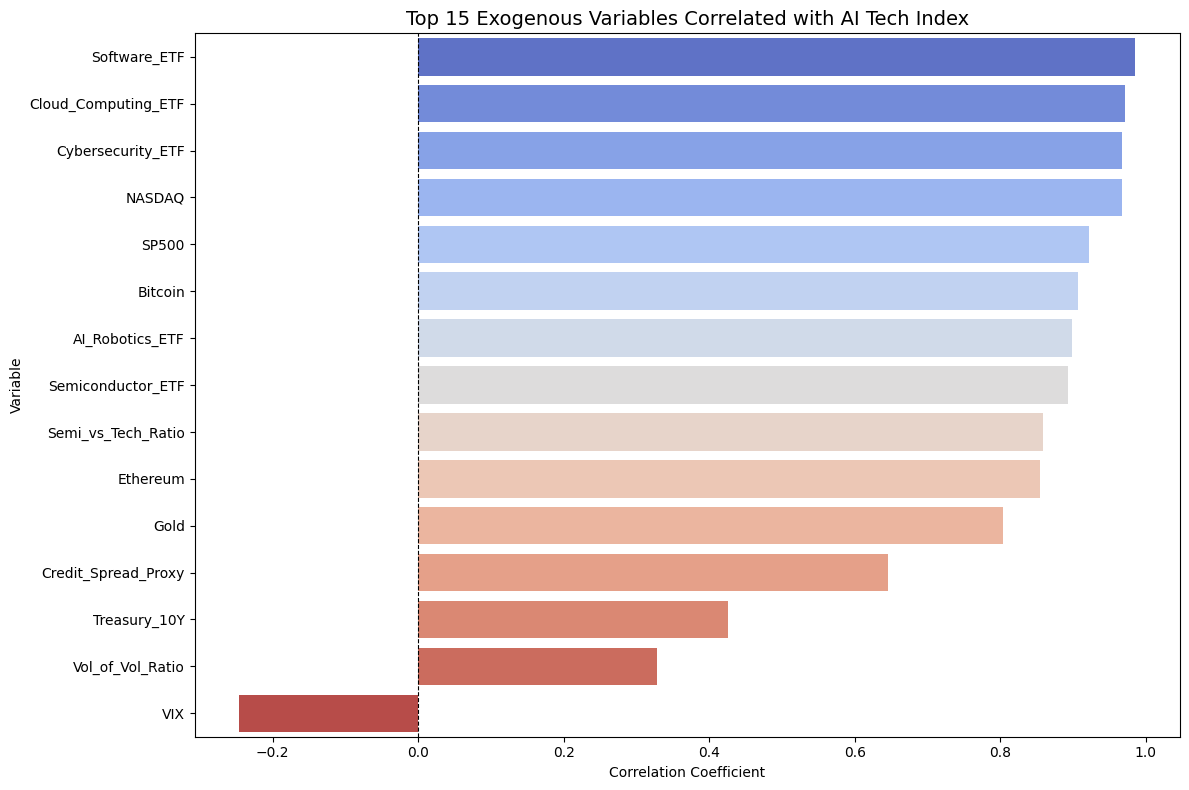


Top Exogenous Variables for SARIMAX Model:
           Variable  Correlation
       Software_ETF     0.985546
Cloud_Computing_ETF     0.971362
  Cybersecurity_ETF     0.967268
             NASDAQ     0.967214
              SP500     0.922636
            Bitcoin     0.907477
    AI_Robotics_ETF     0.898457
  Semiconductor_ETF     0.893224
 Semi_vs_Tech_Ratio     0.859057
           Ethereum     0.854327
               Gold     0.804409
Credit_Spread_Proxy     0.645777
       Treasury_10Y     0.426152
   Vol_of_Vol_Ratio     0.328759
                VIX    -0.245623


In [65]:
# Identify Top Exogenous Variables Correlated with AI Tech Index
# These will be important for SARIMAX model

exogenous_vars = [
    'VIX', 'NASDAQ', 'SP500', 'Yield_Curve_Slope', 'Dollar_Strength',
    'Bitcoin', 'Ethereum', 'Semiconductor_ETF', 'AI_Robotics_ETF',
    'Cybersecurity_ETF', 'Cloud_Computing_ETF', 'Software_ETF',
    'Treasury_10Y', 'Oil_WTI', 'Gold', 'Crypto_Tech_Corr_20d',
    'Vol_of_Vol_Ratio', 'Semi_vs_Tech_Ratio', 'NASDAQ_Momentum',
    'High_Volatility_Regime', 'Credit_Spread_Proxy'
]

# Calculate correlations
correlations = {}
for var in exogenous_vars:
    if var in df.columns:
        corr_data = df[['AI_Tech_Index', var]].dropna()
        if len(corr_data) > 0:
            corr = corr_data.corr().iloc[0, 1]
            correlations[var] = corr

# Sort by absolute correlation
corr_df = pd.DataFrame(list(correlations.items()), columns=['Variable', 'Correlation'])
corr_df['Abs_Correlation'] = corr_df['Correlation'].abs()
corr_df = corr_df.sort_values('Abs_Correlation', ascending=False)

# Plot top 15
top_n = 15
plt.figure(figsize=(12, 8))
sns.barplot(x='Correlation', y='Variable', data=corr_df.head(top_n), 
            palette='coolwarm')
plt.title(f'Top {top_n} Exogenous Variables Correlated with AI Tech Index', fontsize=14)
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

print("\nTop Exogenous Variables for SARIMAX Model:")
print(corr_df[['Variable', 'Correlation']].head(15).to_string(index=False))

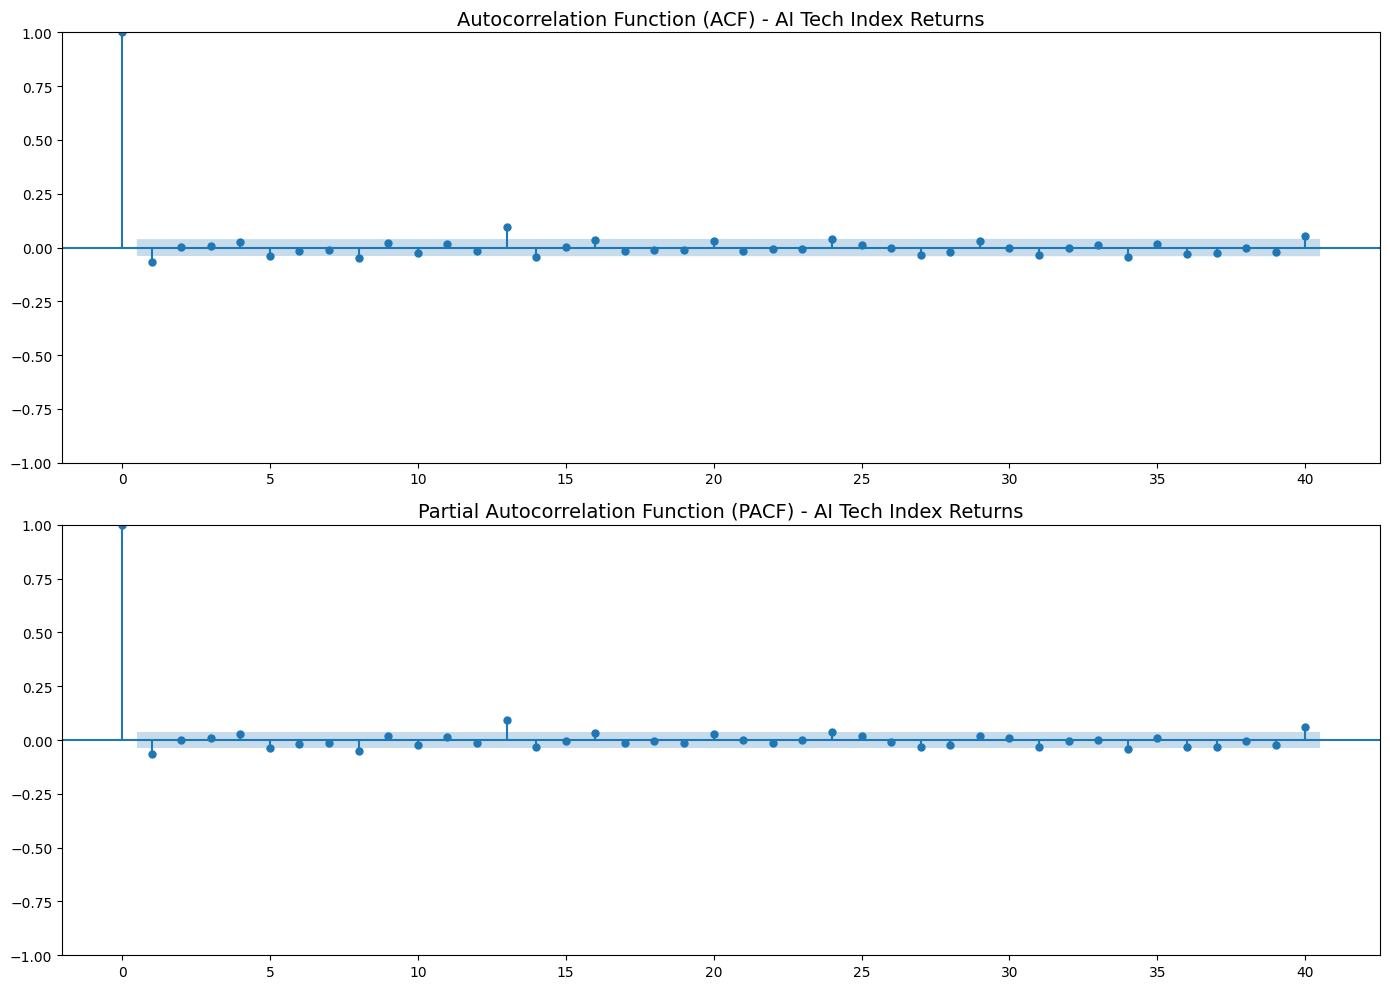

ACF/PACF plots for SARIMAX order selection


In [66]:
# Autocorrelation and Partial Autocorrelation Analysis for SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Use returns for stationarity
returns = df['AI_Tech_Index_Return'].dropna()

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# ACF
plot_acf(returns, lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF) - AI Tech Index Returns', fontsize=14)

# PACF
plot_pacf(returns, lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF) - AI Tech Index Returns', fontsize=14)

plt.tight_layout()
plt.show()

print("ACF/PACF plots for SARIMAX order selection")

In [67]:
# Stationarity Test (Augmented Dickey-Fuller Test)
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name):
    """Perform Augmented Dickey-Fuller test"""
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'\n{name}:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    
    if result[1] <= 0.05:
        print(f"✓ Series is STATIONARY (reject null hypothesis, p < 0.05)")
    else:
        print(f"✗ Series is NON-STATIONARY (fail to reject null hypothesis, p >= 0.05)")

# Test stationarity
print("="*60)
print("STATIONARITY TESTS FOR SARIMAX MODELING")
print("="*60)

# Test index levels (typically non-stationary)
adf_test(df['AI_Tech_Index'], 'AI Tech Index (Levels)')

# Test returns (typically stationary)
adf_test(df['AI_Tech_Index_Return'], 'AI Tech Index (Returns)')

# Test first difference
df['AI_Tech_Index_Diff'] = df['AI_Tech_Index'].diff()
adf_test(df['AI_Tech_Index_Diff'], 'AI Tech Index (First Difference)')

STATIONARITY TESTS FOR SARIMAX MODELING

AI Tech Index (Levels):
ADF Statistic: -1.3613
p-value: 0.6007
Critical Values:
   1%: -3.4341
   5%: -2.8632
   10%: -2.5677
✗ Series is NON-STATIONARY (fail to reject null hypothesis, p >= 0.05)

AI Tech Index (Returns):
ADF Statistic: -13.3048
p-value: 0.0000
Critical Values:
   1%: -3.4330
   5%: -2.8627
   10%: -2.5674
✓ Series is STATIONARY (reject null hypothesis, p < 0.05)

AI Tech Index (First Difference):
ADF Statistic: -37.9011
p-value: 0.0000
Critical Values:
   1%: -3.4352
   5%: -2.8637
   10%: -2.5679
✓ Series is STATIONARY (reject null hypothesis, p < 0.05)


### Summary & Data Preparation for SARIMAX Modeling

In [68]:
# Summary of EDA Findings for SARIMAX Model Development

print("="*70)
print("EDA SUMMARY - AI TECH STOCK FORECASTING")
print("="*70)

print("\n1. TARGET VARIABLE:")
print(f"   - AI Tech Index: Aggregated equal-weighted index of {len([col for col in all_tech_stocks if col in df.columns])} AI-focused tech stocks")
print(f"   - Date Range: {df.index.min()} to {df.index.max()}")
print(f"   - Total Trading Days: {len(df[df['AI_Tech_Index'].notna()])}")

print("\n2. STATIONARITY:")
print("   - Index Levels: Non-stationary (requires differencing)")
print("   - Returns: Stationary (suitable for modeling)")
print("   - Recommendation: Use first difference or returns for SARIMAX")

print("\n3. KEY FINDINGS:")
print(f"   - Average Daily Return: {df['AI_Tech_Index_Return'].mean():.4f}%")
print(f"   - Volatility (Std Dev): {df['AI_Tech_Index_Return'].std():.4f}%")
print(f"   - Cumulative Return: {((df['AI_Tech_Index_Normalized'].dropna().iloc[-1] - 100) / 100 * 100):.2f}%")

print("\n4. TOP EXOGENOUS VARIABLES (for SARIMAX):")
if 'corr_df' in locals():
    for idx, row in corr_df.head(10).iterrows():
        print(f"   - {row['Variable']}: {row['Correlation']:.4f}")

print("\n5. REGIME EFFECTS:")
regime_effects = {
    'AI Boom Period': df[df['AI_Boom_Period'] == 1]['AI_Tech_Index_Return'].mean() if 'AI_Boom_Period' in df.columns else None,
    'Tech Bear 2022': df[df['Tech_Bear_2022'] == 1]['AI_Tech_Index_Return'].mean() if 'Tech_Bear_2022' in df.columns else None,
    'Pandemic Period': df[df['Pandemic_Period'] == 1]['AI_Tech_Index_Return'].mean() if 'Pandemic_Period' in df.columns else None
}
for regime, avg_return in regime_effects.items():
    if avg_return is not None:
        print(f"   - {regime}: {avg_return:.4f}% avg daily return")

print("\n6. NEXT STEPS:")
print("   ✓ Data is ready for SARIMAX modeling")
print("   ✓ Consider testing multiple SARIMAX orders: (p,d,q)(P,D,Q,s)")
print("   ✓ Include top exogenous variables with high correlations")
print("   ✓ Account for regime changes using binary indicators")
print("   ✓ Split data: Training (2019-2023) / Testing (2024-2025)")

print("\n" + "="*70)

EDA SUMMARY - AI TECH STOCK FORECASTING

1. TARGET VARIABLE:
   - AI Tech Index: Aggregated equal-weighted index of 24 AI-focused tech stocks
   - Date Range: 2019-01-01 00:00:00 to 2025-11-20 00:00:00
   - Total Trading Days: 1733

2. STATIONARITY:
   - Index Levels: Non-stationary (requires differencing)
   - Returns: Stationary (suitable for modeling)
   - Recommendation: Use first difference or returns for SARIMAX

3. KEY FINDINGS:
   - Average Daily Return: 0.0652%
   - Volatility (Std Dev): 1.6966%
   - Cumulative Return: 258.09%

4. TOP EXOGENOUS VARIABLES (for SARIMAX):
   - Software_ETF: 0.9855
   - Cloud_Computing_ETF: 0.9714
   - Cybersecurity_ETF: 0.9673
   - NASDAQ: 0.9672
   - SP500: 0.9226
   - Bitcoin: 0.9075
   - AI_Robotics_ETF: 0.8985
   - Semiconductor_ETF: 0.8932
   - Semi_vs_Tech_Ratio: 0.8591
   - Ethereum: 0.8543

5. REGIME EFFECTS:
   - AI Boom Period: 0.0858% avg daily return
   - Tech Bear 2022: -0.1741% avg daily return
   - Pandemic Period: 0.1685% avg dail

In [69]:
# Export cleaned data for SARIMAX modeling
# Create a clean dataset with only complete cases and key variables

# Select key columns for SARIMAX
sarimax_columns = [
    'AI_Tech_Index', 'AI_Tech_Index_Return',
    'VIX', 'NASDAQ', 'SP500', 'Yield_Curve_Slope', 'Dollar_Strength',
    'Bitcoin', 'Semiconductor_ETF', 'AI_Robotics_ETF', 'Cybersecurity_ETF',
    'Treasury_10Y', 'Oil_WTI', 'Gold', 'Crypto_Tech_Corr_20d',
    'Vol_of_Vol_Ratio', 'Semi_vs_Tech_Ratio', 'NASDAQ_Momentum',
    'High_Volatility_Regime', 'Credit_Spread_Proxy',
    'Pandemic_Period', 'AI_Boom_Period', 'Fed_Hike_Period', 
    'Tech_Bear_2022', 'Banking_Crisis_2023',
    'Month', 'Quarter', 'Day_of_Week'
]

# Filter columns that exist
available_cols = [col for col in sarimax_columns if col in df.columns]

# Create export dataframe
df_export = df[available_cols].copy()

# Remove weekends/holidays (rows with all NaN for stocks)
df_export = df_export[df_export['AI_Tech_Index'].notna()]

print(f"Prepared dataset for SARIMAX modeling:")
print(f"  - Shape: {df_export.shape}")
print(f"  - Date Range: {df_export.index.min()} to {df_export.index.max()}")
print(f"  - Variables: {len(available_cols)}")
print(f"\nMissing values per column:")
print(df_export.isnull().sum().sort_values(ascending=False).head(10))

# Save to CSV
output_path = "Datasets/AI_Tech_Index_SARIMAX_Ready.csv"
df_export.to_csv(output_path)
print(f"\n✓ Data exported to: {output_path}")

Prepared dataset for SARIMAX modeling:
  - Shape: (1733, 28)
  - Date Range: 2019-01-02 00:00:00 to 2025-11-20 00:00:00
  - Variables: 28

Missing values per column:
Dollar_Strength         1733
Crypto_Tech_Corr_20d    1733
NASDAQ_Momentum         1733
Vol_of_Vol_Ratio           8
Bitcoin                    1
AI_Tech_Index_Return       1
NASDAQ                     0
SP500                      0
Semiconductor_ETF          0
VIX                        0
dtype: int64

✓ Data exported to: Datasets/AI_Tech_Index_SARIMAX_Ready.csv
